In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
# input

sumstats_f <- 'INI50.lst'
metal_f <- '/oak/stanford/groups/mrivas/users/ytanigaw/sandbox/20200612_metal_power_analysis/INI50.%s.metal.tsv.gz'
var_anno_cal_f <- '/oak/stanford/groups/mrivas/ukbb24983/cal/variant_filter_table.tsv.gz'


In [3]:
sumstats_list <- fread(sumstats_f, head=F, sep='\t') %>% pull()
sumstats_list <- setNames(
    sumstats_list[1:7],
    c('WB','NBW','Afr','SA','EA','rel','others')
)


In [4]:
metal_pops <- setNames(
    c(
        'WB+NBW+Afr+SA',
        'WB+NBW+Afr+SA+EA',
        'WB+NBW+Afr+SA+rel',
        'WB+NBW+Afr+SA+EA+rel',
        'WB+NBW+Afr+SA+EA+others',
        'WB+NBW+Afr+SA+EA+rel+others'
    ),    
    c(
        '4pops',
        '5pops',
        '5pops-noEA',
        '6pops',
        '6pops-noEA',
        '7pops'
    )
)


## read the variant annotation file

In [5]:
var_anno_cal_df <- fread(var_anno_cal_f, colClasses=c('CHROM'='character'))


In [6]:
var_anno_cal_df %>% 
colnames()

[1] "CHROM"             "POS"               "REF"              
 [4] "ALT"               "ID"                "Gene"             
 [7] "Consequence"       "HGVSp"             "LoF"              
[10] "LoF_filter"        "LoF_flags"         "LoF_info"         
[13] "consequence_field" "f_miss"            "f_miss_bileve"    
[16] "f_miss_wcsg"       "freq"              "hwe_p"            
[19] "maf"               "ld_indep"          "wcsg_only"        
[22] "bileve_only"       "filter"            "missingness"      
[25] "hwe"               "mcpi"              "gnomad_af"        
[28] "mgi"               "mgi_notes"         "all_filters"      
[31] "Gene_symbol"

In [7]:
var_anno_cal_df %>% count(ld_indep)


ld_indep,n
<lgl>,<int>
FALSE,422831
TRUE,361425


In [8]:
ld_indep_lst <- var_anno_cal_df %>% filter(ld_indep) %>% pull(ID)


## read WB sumstats

In [9]:
WB_df <- fread(sumstats_list[['WB']], colClasses=c('#CHROM'='character')) %>%
rename('CHROM'='#CHROM')


In [10]:
WB_sub_df <- WB_df %>% 
filter(ERRCODE=='.', ID %in% ld_indep_lst) %>%
select(CHROM, POS, ID, BETA, SE, P)


In [11]:
WB_sub_df %>% dim()

[1] 361224      6

## Metal
### read metal sumstats

In [12]:
metal_df <- names(metal_pops) %>%
lapply(function(p){
    sprintf(metal_f, p) %>%
    fread(colClasses=c('#CHROM'='character')) %>%
    rename('CHROM'='#CHROM') %>%
    filter(ID %in% ld_indep_lst) %>%
    select(ID, P) %>%
    rename(!! sprintf('%s(%s)', p, metal_pops[[p]]) := 'P')
}) %>%
reduce(function(x, y) full_join(x, y, by='ID'))


### join

In [13]:
df_before_p_val_filter <- metal_df %>% 
gather(Metal_pops, Metal_P, -ID) %>%
drop_na(Metal_P) %>%
left_join(WB_sub_df, by='ID') %>%
drop_na(P)


In [14]:
df_before_p_val_filter %>%
filter((as.numeric(P) < 5e-8) | (as.numeric(Metal_P) < 5e-8)) -> df


In [16]:
df_before_p_val_filter %>% dim() %>% print()
df %>% dim() %>% print()


[1] 2167344       8
[1] 13685     8


### fit lm

In [17]:
df %>%
mutate(tmp = Metal_pops) %>%
separate(tmp, c('Metal_pop_short', NA), sep='\\(') %>%
count(Metal_pop_short)


Metal_pop_short,n
<chr>,<int>
4pops,2039
5pops,2039
5pops-noEA,2338
6pops,2337
6pops-noEA,2464
7pops,2468


In [18]:
df %>%
mutate(tmp = Metal_pops) %>%
separate(tmp, c('Metal_pop_short', NA), sep='\\(') %>%
mutate(log10P = -log10(as.numeric(P)), Metal_log10P = -log10(as.numeric(Metal_P))) -> glm_df


In [19]:
for(p in names(metal_pops)){
    print(sprintf('%s: %s', p, metal_pops[[p]]))
    lm(Metal_log10P ~ 0 + log10P, glm_df %>% filter(Metal_pop_short == p)) %>% print()    
}


[1] "4pops: WB+NBW+Afr+SA"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10P  
 1.063  

[1] "5pops: WB+NBW+Afr+SA+EA"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10P  
 1.063  

[1] "5pops-noEA: WB+NBW+Afr+SA+rel"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10P  
 1.177  

[1] "6pops: WB+NBW+Afr+SA+EA+rel"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10P  
 1.178  

[1] "6pops-noEA: WB+NBW+Afr+SA+EA+others"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10P  
 1.237  

[1] "7pops: WB+NBW+Afr+SA+EA+rel+others"

Call:
lm(formula = Metal_log10P ~ 0 + log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
log10

In [20]:
for(p in names(metal_pops)){
    print(sprintf('%s: %s', p, metal_pops[[p]]))
    lm(Metal_log10P ~ log10P, glm_df %>% filter(Metal_pop_short == p)) %>% print()    
}


[1] "4pops: WB+NBW+Afr+SA"

Call:
lm(formula = Metal_log10P ~ log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
(Intercept)       log10P  
    -0.1287       1.0683  

[1] "5pops: WB+NBW+Afr+SA+EA"

Call:
lm(formula = Metal_log10P ~ log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
(Intercept)       log10P  
    -0.1388       1.0688  

[1] "5pops-noEA: WB+NBW+Afr+SA+rel"

Call:
lm(formula = Metal_log10P ~ log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
(Intercept)       log10P  
   -0.02428      1.17856  

[1] "6pops: WB+NBW+Afr+SA+EA+rel"

Call:
lm(formula = Metal_log10P ~ log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
(Intercept)       log10P  
   -0.02756      1.17892  

[1] "6pops-noEA: WB+NBW+Afr+SA+EA+others"

Call:
lm(formula = Metal_log10P ~ log10P, data = glm_df %>% filter(Metal_pop_short == 
    p))

Coefficients:
(Intercept)       log10P  
   -0.05509      1.23984  

[

### plot

In [21]:
p <- df %>%
ggplot(aes(x = -log10(as.numeric(P)), y = -log10(as.numeric(Metal_P)))) +
geom_abline(slope=1, intercept=0, color='gray') +
theme_bw() +
facet_wrap(~Metal_pops, ncol = 3) +
labs(x = 'WB -log10(P)', y = 'Metal -log10(P)')


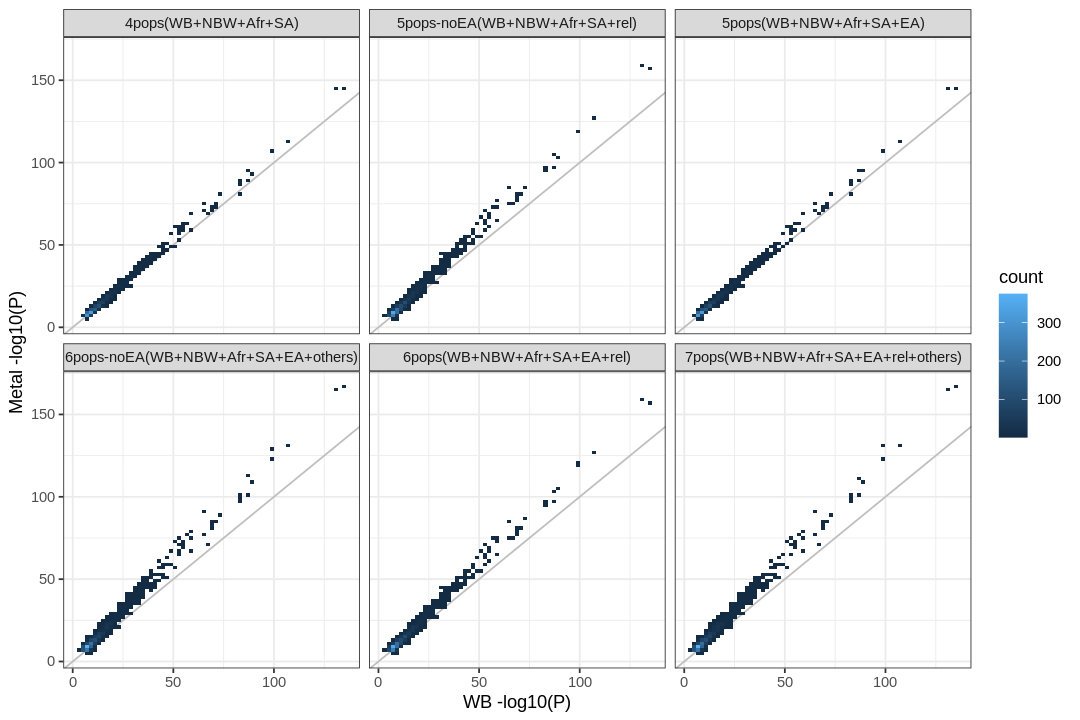

In [22]:
options(repr.plot.width=9, repr.plot.height=6)
p + geom_bin2d(binwidth=c(2, 2))


In [36]:
ggsave('2_compare_pval.png', p + theme_bw(base_size = 9) + geom_bin2d(binwidth=c(2, 2)), width=8, height=5)


Warning message:
“Removed 2292 rows containing non-finite values (stat_bin2d).”

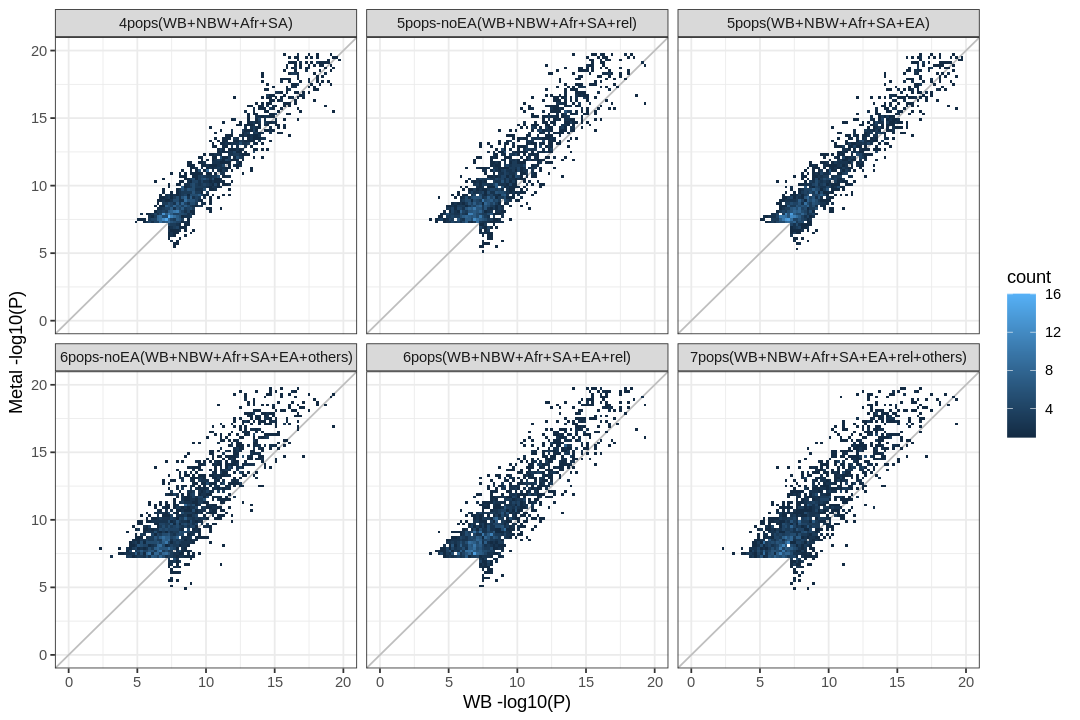

In [23]:
options(repr.plot.width=9, repr.plot.height=6)
p + geom_bin2d(binwidth=c(.2, .2)) + xlim(0, 20) + ylim(0, 20)


## sumstats comparison

In [25]:
sumstats_pops_df <- names(sumstats_list)[2:7] %>%
lapply(function(pop){
    sumstats_list[[pop]] %>%
    fread(colClasses=c('#CHROM'='character')) %>%
    rename('CHROM'='#CHROM') %>% 
    drop_na(P) %>%
    filter(ID %in% ld_indep_lst) %>%
    select(CHROM, POS, ID, BETA, SE, P) %>%
    mutate(population=pop)    
}) %>%
bind_rows()


In [26]:
sumstats_pops_df %>%
count(population)

population,n
<chr>,<int>
Afr,325438
EA,188019
NBW,348401
others,350466
rel,354292
SA,322337


In [27]:
p_sumstats <- sumstats_pops_df %>%
left_join(WB_sub_df %>% select(ID, P) %>% rename('WB_P'='P'), by='ID') %>%
filter((as.numeric(P) < 5e-8) | (as.numeric(WB_P) < 5e-8)) %>%
ggplot(aes(x = -log10(as.numeric(WB_P)), y = -log10(as.numeric(P)))) +
geom_abline(slope=1, intercept=0, color='gray') +
theme_bw() +
facet_wrap(~population, ncol = 3) +
labs(x = 'WB -log10(P)', y = '-log10(P)')


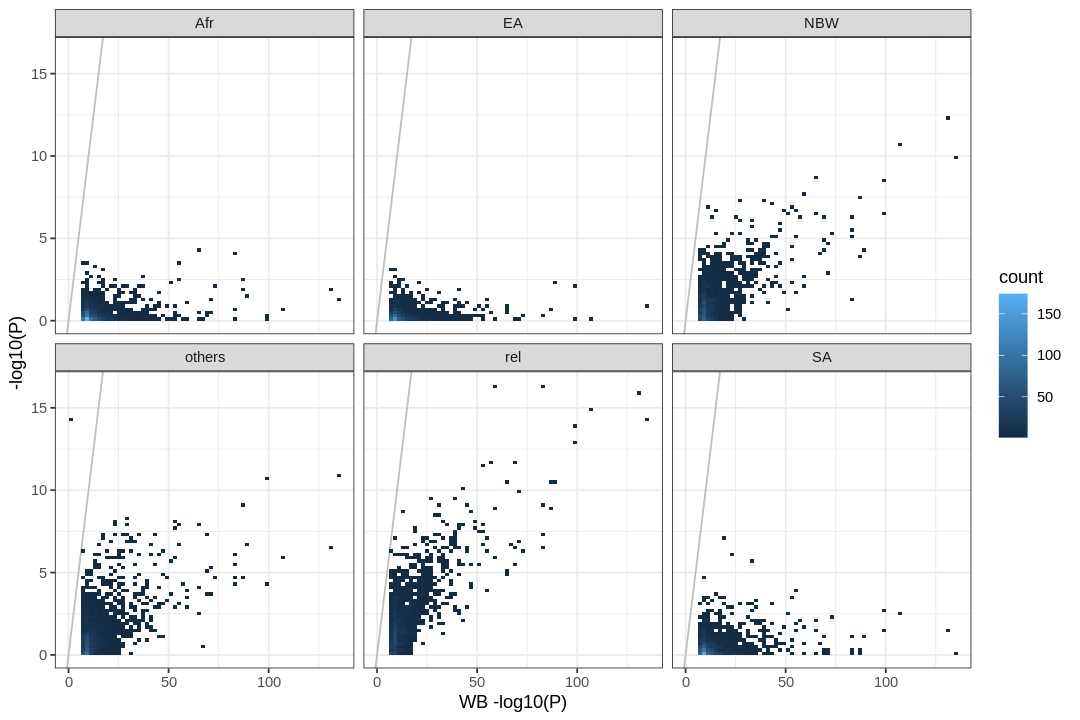

In [28]:
options(repr.plot.width=9, repr.plot.height=6)
p_sumstats + geom_bin2d(binwidth=c(2, 0.2))


Warning message:
“Removed 203 rows containing non-finite values (stat_bin2d).”

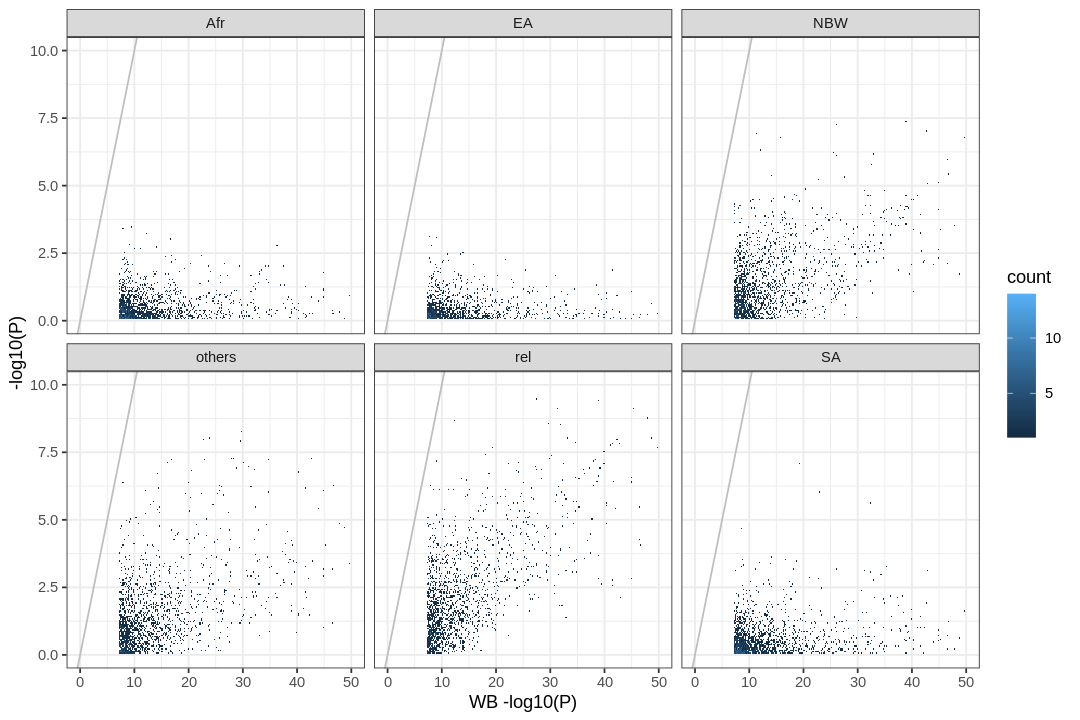

In [29]:
options(repr.plot.width=9, repr.plot.height=6)
p_sumstats + geom_bin2d(binwidth=c(.2, 0.05)) + xlim(0,50) + ylim(0,10)
